In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [2]:
output_file = 'utqiagvik.gpkg'
#gf = gpd.read_parquet(s3path)
gf = gpd.read_file(output_file)

In [3]:
gf.head(2)

time  dh_fit_dx  dh_fit_dy  gt  w_surface_window_final  \
0 2023-01-09 23:39:51.181  -0.004885        0.0  20               17.779561   
1 2023-01-09 23:39:51.184  -2.154382        0.0  20               54.940145   

       distance   h_sigma  pflags  rms_misfit  spot  cycle  rgt  segment_id  \
0  7.947966e+06  0.050964       0    0.134553     5     18  312      396540   
1  7.947986e+06  0.000000       2    0.000000     5     18  312      396541   

      h_mean  n_fit_photons  mosaic.file_id   mosaic.time  mosaic.flags  \
0   1.625571             10               0  1.358109e+12             0   
1 -28.113643             13               0  1.358109e+12             0   

   mosaic.value                     geometry  
0      1.351868  POINT (-156.36948 71.24078)  
1      1.161150  POINT (-156.36956 71.24096)

In [4]:
subset = gf.drop(columns='time').sample(1000)
subset.explore(column='rgt', categorical=True)

In [5]:
gf.groupby(['cycle','rgt']).first().time.dt.date

cycle  rgt 
18     312     2023-01-09
       373     2023-01-13
       381     2023-01-14
       815     2023-02-11
       823     2023-02-12
       1257    2023-03-12
       1265    2023-03-13
       1326    2023-03-17
19     312     2023-04-10
       381     2023-04-15
Name: time, dtype: object

In [6]:
points = gf[(gf.cycle == 19) & (gf.rgt == 381)]

points.loc[:, 'time'] = points.time.dt.strftime('%Y-%m-%d')

points['dzdt'] = points['h_mean'] - points['mosaic.value']

date = points.iloc[0].time
date

/tmp/ipykernel_569/504302764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points.loc[:, 'time'] = points.time.dt.strftime('%Y-%m-%d')
/tmp/ipykernel_569/504302764.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  points.loc[:, 'time'] = points.time.dt.strftime('%Y-%m-%d')
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

'2023-04-15'

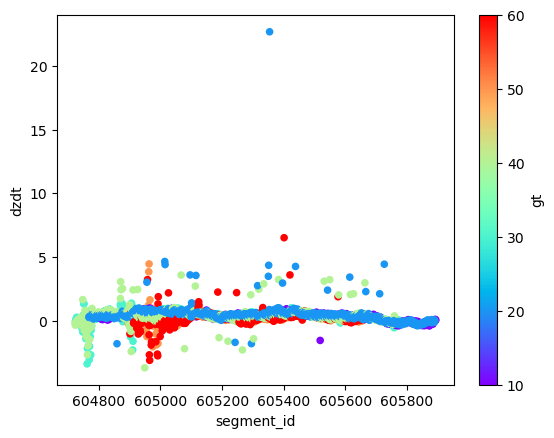

In [7]:
# NOTE: outlier at dzdt=20, so set map colorscale accordingly
ax = points.plot.scatter(y='dzdt',x='segment_id', c='gt', cmap='rainbow');

In [8]:
#https://xyzservices.readthedocs.io/en/stable/introduction.html
import xyzservices

In [9]:
# Time-stamped basemap tiles!

terra_snow = xyzservices.providers.NASAGIBS.ModisTerraSnowCover(time=date)
#aqua_snow = xyzservices.providers.NASAGIBS.ModisASnowCover(time=date)

terra_vis = xyzservices.providers.NASAGIBS.ModisTerraTrueColorCR(time=date)
aqua_vis = xyzservices.providers.NASAGIBS.ModisAquaTrueColorCR(time=date)

#viirs = xyzservices.providers.NASAGIBS.ViirsTrueColorCR(time=date)
gdem = xyzservices.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief


In [10]:
# Lots of other great ones, some require tokens:

#terrain = xyzservices.providers.AzureMaps.MicrosoftTerraMain

In [11]:
#https://xyzservices.readthedocs.io/en/stable/introduction.html

#TODO: add title with date, split tile control

# Change to any datestring below (like '2023-08-09')
mytiles = xyzservices.providers.NASAGIBS.ModisTerraSnowCover(time=date) 
#mytiles = xyzservices.providers.Esri.WorldImagery()

m = points.explore(column='dzdt', tiles=mytiles, vmin=-1, vmax=1, cmap='bwr')
m